In [57]:
import json, os, sys
from itertools import combinations

from utils import *

import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
with open('../rawdata/msd_subset_audio_features.json', 'r') as f:
    merged_features_raw = json.load(f)

with open('../rawdata/msd_taste_profile_no-lyrics.json', 'r') as f:
    taste_profile_raw = json.load(f)

In [3]:
len(merged_features_raw), len(taste_profile_raw)

(10000, 404103)

In [4]:
# Normalize content features to [0, 1]
max_features = {
    'duration': -np.inf,
    'key': -np.inf,
    'key_confidence': -np.inf,
    'mode': -np.inf,
    'mode_confidence': -np.inf,
    'loudness': -np.inf,
    'tempo': -np.inf,
    'time_signature': -np.inf,
    'time_signature_confidence': -np.inf,
}

min_features = {
    'duration': np.inf,
    'key': np.inf,
    'key_confidence': np.inf,
    'mode': np.inf,
    'mode_confidence': np.inf,
    'loudness': np.inf,
    'tempo': np.inf,
    'time_signature': np.inf,
    'time_signature_confidence': np.inf,
}

for _, features in merged_features_raw.items():
    for feature, value in features.items():
        if feature in max_features:
            max_features[feature] = max(max_features[feature], value)
            min_features[feature] = min(min_features[feature], value)
            
max_features, min_features

({'duration': 1819.76771,
  'key': 11.0,
  'key_confidence': 1.0,
  'mode': 1.0,
  'mode_confidence': 1.0,
  'loudness': 0.566,
  'tempo': 262.828,
  'time_signature': 7.0,
  'time_signature_confidence': 1.0},
 {'duration': 1.04444,
  'key': 0.0,
  'key_confidence': 0.0,
  'mode': 0.0,
  'mode_confidence': 0.0,
  'loudness': -51.643,
  'tempo': 0.0,
  'time_signature': 0.0,
  'time_signature_confidence': 0.0})

In [5]:
def process_features(features):
    # Filter out unrecognized features
    feature_subset = { feature_name: features[feature_name] for feature_name in max_features }
    
    # Normalize recognized features
    for feature, value in feature_subset.items():
        if feature in max_features:
            feature_subset[feature] = (value - min_features[feature]) / (max_features[feature] - min_features[feature])
            
    return feature_subset

In [6]:
merged_features_processed = { track_id: process_features(features) for track_id, features in merged_features_raw.items() }

In [7]:
user_profiles, user_setlists = generate_user_profile(taste_profile_raw, merged_features_processed)

In [8]:
average_user_profiles = {}
user_setlists = {}

for user_id, tracklist in taste_profile_raw.items():
    initial = {
        'duration': 0,
        'key': 0,
        'key_confidence': 0,
        'mode': 0,
        'mode_confidence': 0,
        'loudness': 0,
        'tempo': 0,
        'time_signature': 0,
        'time_signature_confidence': 0,
    }
    user_setlists[user_id] = {}
    
    # Generate weighted average of features
    total_track_counts = 0
    
    for track in tracklist:
        track_id, count = track['track'], track['count']
        if track_id not in merged_features_processed:
            raise 'AAAAA'
        
        total_track_counts += count
        user_setlists[user_id][track_id] = count
        
        track_features = merged_features_processed[track_id]
        for feature, value in track_features.items():
            initial[feature] += value * count
            
    for feature in initial:
        initial[feature] /= total_track_counts
    
    average_user_profiles[user_id] = initial

len(average_user_profiles)

404103

In [9]:
def dict_euclidean_distance(a, b):
    return np.linalg.norm(np.array(list(a.values())) - np.array(list(b.values())))

def dict_manhtattan_distance(a, b):
    return np.sum(np.abs(np.array(list(a.values())) - np.array(list(b.values()))))

# Define a user's rating of a track as the number of times they listened to it
# If they haven't listened to it, define rating as the similarity (i.e. inverse distance) between the user's average profile and the track's features
def user_rating(user_id, track_id, distance_func: callable=dict_euclidean_distance):
    if track_id in user_setlists[user_id]:
        return user_setlists[user_id][track_id]
    else:
        user_avg_features = average_user_profiles[user_id]
        track_features = merged_features_processed[track_id]
        
        return 1 / (1 + distance_func(user_avg_features, track_features))        

In [10]:
def pearson_user_sim(user_id1, user_id2):
    combined_songs = set([*user_setlists[user_id1].keys(), *user_setlists[user_id2].keys()])
    n_songs = len(combined_songs)
    
    user1_ratings = np.zeros(n_songs)
    user2_ratings = np.zeros(n_songs)
    
    for i, song in enumerate(combined_songs):
        user1_ratings[i] = user_rating(user_id1, song)
        user2_ratings[i] = user_rating(user_id2, song)
    
    user1_ratings[:] -= np.mean(user1_ratings)
    user2_ratings[:] -= np.mean(user2_ratings)
    
    num = np.dot(user1_ratings, user2_ratings)
    den = np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings)
    
    if num == 0 and den == 0:
        return 1
    
    return num / den

def cosine_user_sim(user_id1, user_id2):
    combined_songs = set([*user_setlists[user_id1].keys(), *user_setlists[user_id2].keys()])
    n_songs = len(combined_songs)
    
    user1_ratings = np.zeros(n_songs)
    user2_ratings = np.zeros(n_songs)
    
    for i, song in enumerate(combined_songs):
        user1_ratings[i] = user_rating(user_id1, song)
        user2_ratings[i] = user_rating(user_id2, song)
    
    num = np.dot(user1_ratings, user2_ratings)
    den = np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings)
    
    if num == 0 and den == 0:
        return 0
    
    return num / den

In [11]:
# Generate user ID to index mapping
userid_to_index = { user_id: i for i, user_id in enumerate(average_user_profiles.keys()) }
index_to_userid = { v: k for k, v in userid_to_index.items() }

In [15]:
RAND_SEED = 221
rand = np.random.default_rng(RAND_SEED)

In [44]:
def simulate_subset(subset_size, rand, neighborhood_sizes):
    # Generate random user subset
    # subset_size = 5000
    user_subset = rand.choice(len(average_user_profiles), subset_size, replace=False)
    index_subset_mapping = { i: index_to_userid[user_id] for i, user_id in enumerate(user_subset) }
    subset_index_mapping = { v: k for k, v in index_subset_mapping.items() }
    
    print(f'Generating similarity matrix for subset of size {subset_size}...')
    user_similarity = np.full((subset_size, subset_size), -np.inf)
    total_sims = (subset_size * (subset_size - 1)) // 2

    for i, pair in enumerate(combinations(index_subset_mapping, 2)):
        if i % 2500 == 0:
            print(f'{i=}/{total_sims} | {(i/total_sims * 100):.3f}%', end='\r')
        
        user1, user2 = pair
        sim = cosine_user_sim(index_subset_mapping[user1], index_subset_mapping[user2])
        
        user_similarity[user1][user2] = sim
        user_similarity[user2][user1] = sim
    print()
        
    user_similarity_sorted = np.argsort(user_similarity)
    
    # Uses the similarity matrix to generate neighborhoods of size n
    # This is pretty awful code, but it'll do. Anyways, we're data scientists, not software engineers
    def run_neighborhood_analysis(neighborhood_size):
        print(f'>> Generating neighborhood of size {neighborhood_size}...', end='\r')
        user_neighborhoods = {}
        
        for i, row in enumerate(user_similarity_sorted):
            user_neighborhoods[index_subset_mapping[i]] = [index_subset_mapping[n] for n in row[-neighborhood_size:]]
            
        def predict_rating(user_id, track_id):
            user_index = subset_index_mapping[user_id]
            neighborhood = user_neighborhoods[user_id]
            
            neighborhood_ratings = [user_rating(neighbor, track_id) for neighbor in neighborhood]
            
            similarities = [user_similarity[user_index][subset_index_mapping[neighbor]] for neighbor in neighborhood]
            
            num = np.dot(similarities, neighborhood_ratings)
            den = np.abs(similarities).sum()
            
            # print(num, den)
            if num == 0 or den == 0:
                return 0

            return num / den
        
        squared_error = 0
        abs_error = 0
        run_count = 0
        for user in user_neighborhoods:
            for track in taste_profile_raw[user]:
                track_id = track['track']
                
                prediction = predict_rating(user, track_id)
                actual = track['count']
                
                abs_error += np.abs(prediction - actual)
                squared_error += (prediction - actual) ** 2
                run_count += 1

        return squared_error / run_count, abs_error / run_count
    
    neighborhood_analysis = [run_neighborhood_analysis(n) for n in neighborhood_sizes]
    print()
    
    return user_similarity, subset_index_mapping, index_subset_mapping, neighborhood_analysis

In [ ]:
subset_sizes = [100, 500, 2500, 5000]
neighborhood_sizes = [2, 3, 5, 10, 15, 25, 50, 100, 250, 500]

results = {}

for size in subset_sizes:
    results[size] = simulate_subset(size, rand, [s for s in neighborhood_sizes if s < size])[3]
    
results

/tmp/ipykernel_15648/957078498.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


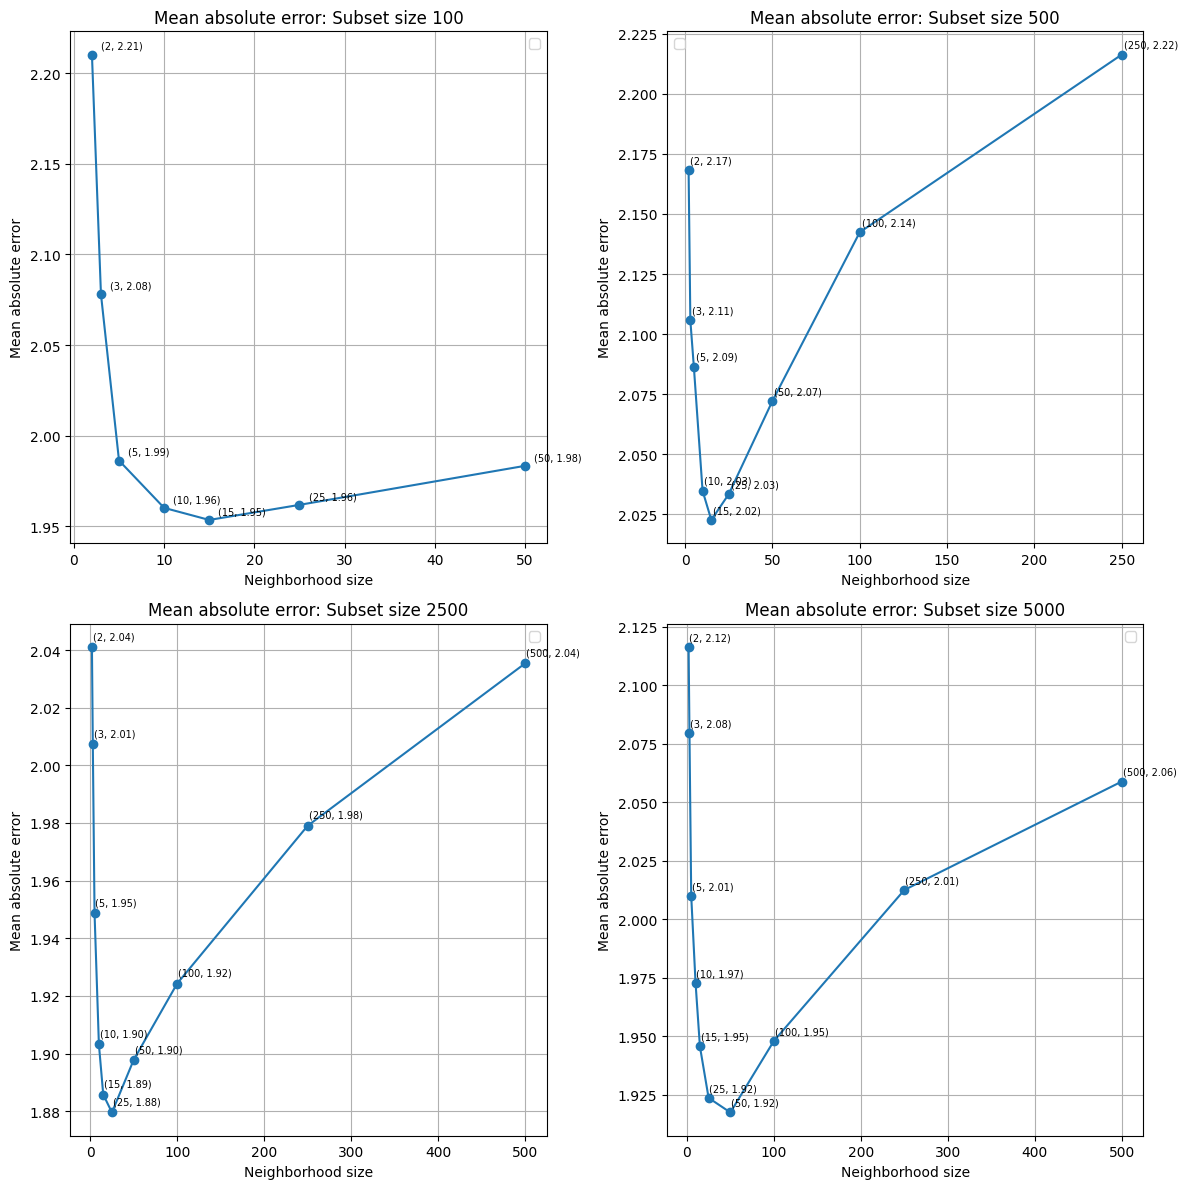

In [82]:
# Plot results, one line for each subset size

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# texts = []

for i, ax in enumerate(axs.flatten()):
    size = subset_sizes[i]
    this_neighborhood_sizes = [s for s in neighborhood_sizes if s < size]
    
    ax.plot(this_neighborhood_sizes, [r[1] for r in results[size]], marker='o')
    
    # t = []
    for i, _ in enumerate(this_neighborhood_sizes):
        ax.text(this_neighborhood_sizes[i] + 1, results[size][i][1] + 0.002, f'({this_neighborhood_sizes[i]}, {results[size][i][1]:.2f})', fontsize=7, ha='left', va='bottom')
        # t.append(ax.text(this_neighborhood_sizes[i], results[size][i][1], f'({this_neighborhood_sizes[i]}, {results[size][i][1]:.2f})', fontsize=7))
        # texts.append(t)
        
    ax.set_title(f'Mean absolute error: Subset size {size}')
    ax.set_xlabel('Neighborhood size')
    ax.set_ylabel('Mean absolute error')
    ax.legend()
    ax.grid(True)
    
# for i, ax in enumerate(axs.flatten()):
#     adjust_text(texts[i], ax=ax, arrowprops=dict(arrowstyle='->', color='red'))
    
plt.tight_layout()
plt.show()

# for size in subset_sizes:
#     this_neighborhood_sizes = [s for s in neighborhood_sizes if s < size]
    
#     plt.plot(this_neighborhood_sizes, [r[1] for r in results[size]], label=f'Subset size {size}', marker='o')
    
#     for i, _ in enumerate(this_neighborhood_sizes):
#         texts.append(plt.text(this_neighborhood_sizes[i], results[size][i][1], f'({this_neighborhood_sizes[i]:.2f}, {results[size][i][1]:.2f})', fontsize=7))
    

# plt.title('Mean absolute error by neighborhood size')
# plt.xlabel('Neighborhood size')
# plt.ylabel('Mean absolute error')
# plt.legend()

todo:
- training process:
  - for each of user's songs:
    - generate recommendations using other 

combining both hybrid feature and interaction models:
- convert msd taste profile into piki-like interactions
  - run interaction model using said data
  - run feature model similarly
  - weighted average of both models' outputs
- 

In [ ]:
# # Generate random user subset
# subset_size = 5000
# user_subset = rand.choice(len(average_user_profiles), subset_size, replace=False)
# index_subset_mapping = { i: index_to_userid[user_id] for i, user_id in enumerate(user_subset) }
# subset_index_mapping = { v: k for k, v in index_subset_mapping.items() }
# user_similarity = np.full((subset_size, subset_size), -np.inf)
# total_sims = (subset_size * (subset_size - 1)) // 2

# for i, pair in enumerate(combinations(index_subset_mapping, 2)):
#     if i % 2500 == 0:
#         print(f'{i=}/{total_sims} | {(i/total_sims * 100):.3f}%', end='\r')
    
#     user1, user2 = pair
#     sim = cosine_user_sim(index_subset_mapping[user1], index_subset_mapping[user2])
    
#     user_similarity[user1][user2] = sim
#     user_similarity[user2][user1] = sim
# def run_neighborhood_analysis(neighborhood_size):
#     print(f'Generating neighborhood of size {neighborhood_size}...')
#     user_neighborhoods = {}
    
#     for i, row in enumerate(user_similarity):
#         user_neighborhoods[index_subset_mapping[i]] = [index_subset_mapping[n] for n in np.argsort(row)[-neighborhood_size:]]
        
#     def predict_rating(user_id, track_id):
#         user_index = subset_index_mapping[user_id]
#         neighborhood = user_neighborhoods[user_id]
        
#         neighborhood_ratings = [user_rating(neighbor, track_id) for neighbor in neighborhood]
        
#         similarities = [user_similarity[user_index][subset_index_mapping[neighbor]] for neighbor in neighborhood]
        
#         num = np.dot(similarities, neighborhood_ratings)
#         den = np.abs(similarities).sum()
        
#         return num / den
    
#     error = 0
#     run_count = 0
#     for user in user_neighborhoods:
#         for track in taste_profile_raw[user]:
#             track_id = track['track']
            
#             prediction = predict_rating(user, track_id)
#             actual = track['count']
            
#             error += (prediction - actual) ** 2
#             run_count += 1

#     return error / run_count